In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline


import os

data_path = '/home/fterroso/data/'

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from datetime import date, timedelta

def generate_target_days_fn(init_date, final_date):

    delta = e_date - i_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = i_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [4]:
import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
target_days = generate_target_days_fn(i_date, e_date)

In [5]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join('data', 'OD', 'date_{}_OD_{}_prov_cluster.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [6]:
twt_ods = read_OD_fn('TWT')

In [7]:
ine_ods = read_OD_fn('INE')

## Number of origins and destinations per PROV

In [8]:
def generate_avg_n_origin_destinations_fn(global_od, source, trip_rate_threshold):
    norm_twt_od_global = global_od.div(global_od['total'], axis=0)
    norm_twt_od_global['n_meaningful_dest'] = norm_twt_od_global.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    trasnsposed_norm_od= norm_twt_od_global.T
    trasnsposed_norm_od['n_meaningful_dest'] = trasnsposed_norm_od.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    norm_twt_od_global['type'] = 'destination'
    trasnsposed_norm_od['type'] = 'origin'
    
    df = pd.concat([trasnsposed_norm_od['n_meaningful_dest type'.split()],
                norm_twt_od_global['n_meaningful_dest type'.split()]], axis=0)
    
    df['source']= source
    
    return df

In [9]:
def generate_n_origin_dest_global_fn(trip_rate_threshold):
    twt_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov_cluster.csv'), index_col=0)
    #twt_od_global = twt_od_global.drop(columns='total')
    twt_od_global = twt_od_global.drop('total')
    twt_n_origin_dest_df = generate_avg_n_origin_destinations_fn(twt_od_global, 'TWT', trip_rate_threshold)
    
    ine_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD_prov_cluster.csv'), index_col=0)
    #ine_od_global = ine_od_global.drop(columns='total')
    ine_od_global = ine_od_global.drop('total')
    ine_n_origin_dest_df = generate_avg_n_origin_destinations_fn(ine_od_global, 'INE', trip_rate_threshold)
    
    _df = pd.concat([twt_n_origin_dest_df, ine_n_origin_dest_df], axis=0)
    _df= _df.drop(['total', 'n_meaningful_dest'])
    return _df

In [10]:
n_origin_dest_0_df = generate_n_origin_dest_global_fn(0)

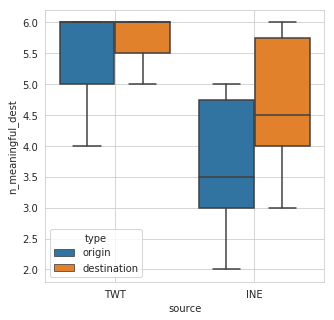

In [11]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_0_df, x='source', y='n_meaningful_dest',hue='type', showfliers = False);
ax.grid(True)

In [12]:
n_origin_dest_005_df = generate_n_origin_dest_global_fn(0.1)

In [13]:
n_origin_dest_005_df

,n_meaningful_dest,type,source
0,5,origin,TWT
1,5,origin,TWT
2,2,origin,TWT
3,3,origin,TWT
4,1,origin,TWT
6,0,origin,TWT
5,0,origin,TWT
0,4,destination,TWT
1,3,destination,TWT
2,4,destination,TWT


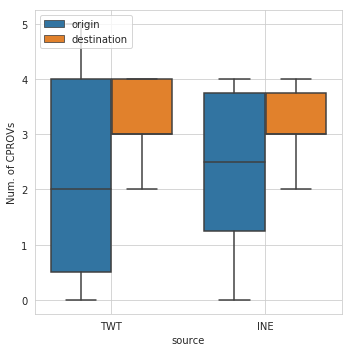

In [14]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_005_df, x='source', y='n_meaningful_dest',hue='type', showfliers = False);
ax.set_ylabel("Num. of CPROVs")
ax.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(os.path.join('figs', 'n_origin_dest_prov_cluster.png'))

## Distribution of distances

In [15]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), driver='GeoJSON')

In [16]:
province_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,geometry
0,34104600000,València/Valencia,46,"MULTIPOLYGON (((653037.661 4429500.236, 652229..."
1,34084500000,Toledo,45,"POLYGON ((294238.465 4416957.428, 294235.467 4..."
2,34024400000,Teruel,44,"POLYGON ((765333.011 4512252.351, 764732.031 4..."
3,34094300000,Tarragona,43,"MULTIPOLYGON (((813560.435 4504876.753, 813537..."
4,34074200000,Soria,42,"POLYGON ((583890.589 4603311.305, 583939.589 4..."


In [17]:
def calculate_distances_fn(prov_o, prov_d):
    
    prov_o = prov_o.zfill(2)
    prov_d = prov_d.zfill(2)
    
    #print(prov_o, prov_d)
    try:
        po_centroid = province_gdf[province_gdf['CODEUNIT']==str(prov_o)]['geometry'].iloc[0].centroid
        pd_centroid = province_gdf[province_gdf['CODEUNIT']==str(prov_d)]['geometry'].iloc[0].centroid
    except:
        return 0
    return po_centroid.distance(pd_centroid)/1000

In [18]:
def generate_ranking_from_od_fn(global_od, source):
    
    od_no_total= global_od.drop('total')
    od_no_totals= od_no_total.drop(columns='total')
    trips_rank_df = od_no_totals.rank(ascending=False, method='first', axis=1)
    
    distance_ranking_list= [] 
    for o_, row in trips_rank_df.iterrows():
        meaningful_dest = row[row<=10]
        for d_, rank_ in meaningful_dest.items():
            dist = calculate_distances_fn(str(o_), str(d_))#ma_distance_od_df.loc[o_,d_]
            if dist > 0:
                distance_ranking_list.append((o_, d_, rank_, dist, source))
    
    distance_ranking_df = pd.DataFrame.from_records(distance_ranking_list, columns='origin destination ranking distance source'.split())
    return distance_ranking_df

In [19]:
twt_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov_cluster.csv'), index_col=0)

In [20]:
twt_od_global.tail()

,0,1,2,3,4,6,5,total
3,732,1677,51,0,14,0,0,2474
4,466,16503,1006,153,0,0,11,18139
6,2798,72,14,41,4870,0,1,7796
5,82758,66490,25985,84101,9666,0,0,269000
total,150948,98247,51810,154026,17745,0,176,472952


In [21]:
twt_trips_rank_df = generate_ranking_from_od_fn(twt_od_global, 'TWT')

In [22]:
ine_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD_prov_cluster.csv'), index_col=0)

In [23]:
ine_trips_rank_df = generate_ranking_from_od_fn(ine_od_global, 'INE')

In [24]:
trips_rank_df = pd.concat([twt_trips_rank_df, ine_trips_rank_df], axis=0)

In [25]:
trips_rank_df.head()

,origin,destination,ranking,distance,source
0,1,2,2.0,449.475826,TWT
1,1,3,4.0,516.687639,TWT
2,1,4,3.0,626.741384,TWT
3,1,6,7.0,541.467874,TWT
4,1,5,5.0,312.278403,TWT


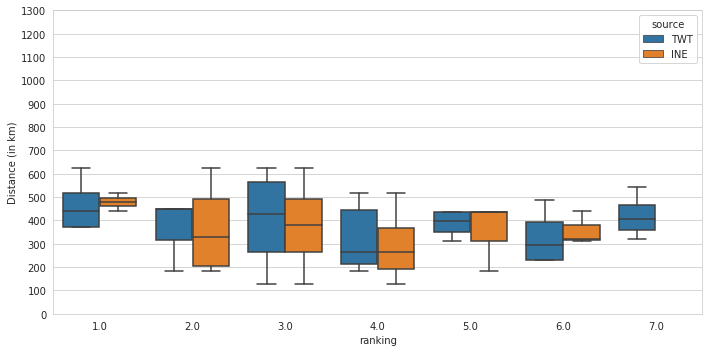

In [26]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
g= sns.boxplot(data=trips_rank_df, x='ranking', y='distance', hue='source', showfliers = False);
g.set_yticks(np.arange(0,1400,100));
g.set_ylabel("Distance (in km)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'distances_origin_dest_prov_cluster.png'))

## Comparison methods

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
def compare_column_ODs_fn(twt_od, ine_od,date_):
    twt_od = twt_od.fillna(0)
    ine_od = ine_od.fillna(0)
    results = []
    ids_ = ine_od.columns.tolist()
    for id_ in ids_:
        row_twt= twt_od[id_]
        row_ine = ine_od[id_]
        
        #columns_ine = row_ine[row_ine>0].index.tolist().remove('total')
        #columns_twt = row_twt[row_twt>0].index.tolist().remove('total')
        
        #target_columns = set(columns_ine).union(set(columns_twt))
        
        columns_ine = row_ine[row_ine>0].index.tolist()
        columns_twt = row_twt[row_twt>0].index.tolist()
        if 'total' in columns_ine:
            columns_ine.remove('total')
            
        if 'total' in columns_twt:
            columns_twt.remove('total')
            
        target_columns = set(columns_ine).union(set(columns_twt))
        
        if len(target_columns)>0:
            #target_columns.remove('total')
            frow_twt = row_twt[target_columns]
            frow_ine = row_ine[target_columns]

            norm_rown_ine= frow_ine
            sum_ine= sum(frow_ine)
            if sum_ine >0:
                norm_rown_ine= frow_ine/sum_ine

            norm_rown_twt= frow_twt
            sum_twt= sum(frow_twt)
            if sum_twt>0:
                norm_rown_twt= frow_twt/sum_twt

            corr_= frow_ine.corr(frow_twt)           
            rmse_= mean_squared_error(norm_rown_ine, norm_rown_twt)           
            
            intersect_columns = set(columns_ine).intersection(set(columns_twt))
            overlap = len(intersect_columns)/len(target_columns)

            results.append((id_, corr_, rmse_, overlap, date_))
    
    return results

In [29]:
def compare_row_ODs_fn(twt_od, ine_od,date_):
    twt_od = twt_od.fillna(0)
    ine_od = ine_od.fillna(0)
    results = []
    ids_ = ine_od.index.tolist()
    for id_ in ids_:
        row_twt= twt_od.loc[id_]
        row_ine = ine_od.loc[id_]
               
        columns_ine = row_ine[row_ine>0].index.tolist()
        columns_twt = row_twt[row_twt>0].index.tolist()
        if 'total' in columns_ine:
            columns_ine.remove('total')
            
        if 'total' in columns_twt:
            columns_twt.remove('total')
            
        target_columns = set(columns_ine).union(set(columns_twt))
        if len(target_columns)>0:
            #target_columns.remove('total')
            frow_twt = row_twt[target_columns]
            frow_ine = row_ine[target_columns]

            norm_rown_ine= frow_ine
            sum_ine= sum(frow_ine)
            if sum_ine >0:
                norm_rown_ine= frow_ine/sum_ine

            norm_rown_twt= frow_twt
            sum_twt= sum(frow_twt)
            if sum_twt>0:
                norm_rown_twt= frow_twt/sum_twt

            corr_= frow_ine.corr(frow_twt)           
            rmse_= mean_squared_error(norm_rown_ine, norm_rown_twt)
            
            intersect_columns = set(columns_ine).intersection(set(columns_twt))
            overlap = len(intersect_columns)/len(target_columns)

            results.append((id_, corr_, rmse_, overlap, date_))
    
    return results

In [30]:
def generate_comparive_fn(axis=0):
    all_results = []
    comparison_method = compare_row_ODs_fn
    if axis==1:
        comparison_method= compare_column_ODs_fn
        
    for d in tqdm_notebook(target_days):
        date_results = comparison_method(twt_ods[d], ine_ods[d],d)
        all_results= all_results + date_results
    results_df = pd.DataFrame.from_records(all_results, columns='MA_id corr rmse overlap date'.split())
    results_df= results_df.dropna(axis=0)
    results_df['date'] = results_df['date'].astype(str)
    
    return results_df

## Compare outgoing flows

In [31]:
date_results_df=generate_comparive_fn(axis=0)

In [32]:
date_results_df.head()

,MA_id,corr,rmse,overlap,date
0,0,0.902547,0.013971,0.750000,2020-04-01
1,1,0.757239,0.029724,0.500000,2020-04-01
2,2,0.956325,0.020777,0.666667,2020-04-01
3,3,1.000000,0.193600,0.500000,2020-04-01
4,4,-1.000000,1.000000,0.000000,2020-04-01


In [33]:
date_results_df = date_results_df[date_results_df['MA_id']!= 'total']

In [34]:
import seaborn as sns

### RMSE

In [35]:
median_date_results_df= date_results_df.groupby('date')['rmse'].median().to_frame()

In [36]:
median_date_results_df.reset_index().head()

,date,rmse
0,2020-04-01,0.029724
1,2020-04-02,0.098140
2,2020-04-03,0.021570
3,2020-04-04,0.083425
4,2020-04-05,0.055363


In [37]:
median_date_results_df['rmse'].mean()

0.04559380315652574

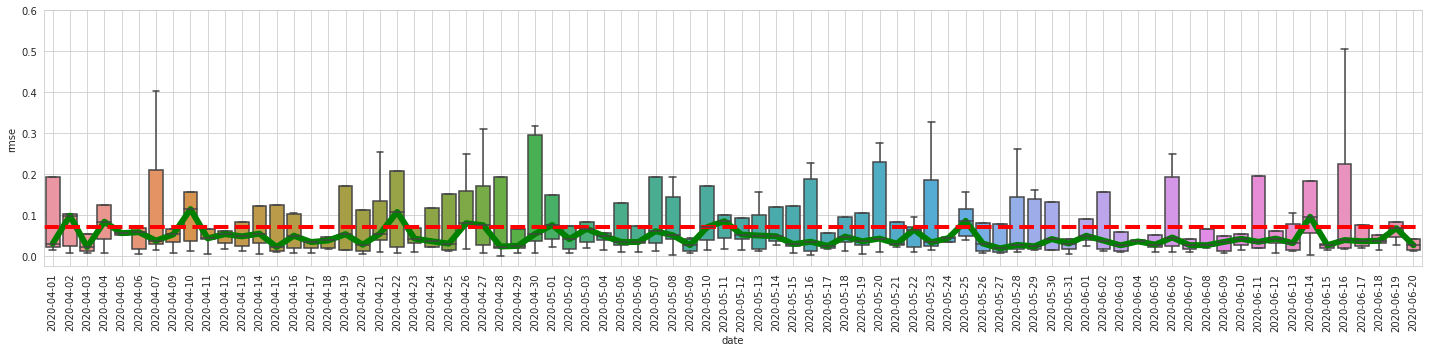

In [38]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='rmse',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='rmse',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,0.7,0.1))

ax.axhline(0.07, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("RMSE evolution (outgoing flow)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'rmse_outgoing_prov_cluster.png'))

### Destinations overlap

In [39]:
median_date_results_df= date_results_df.groupby('date')['overlap'].median().to_frame()

In [40]:
median_date_results_df['overlap'].mean()

0.5114583333333333

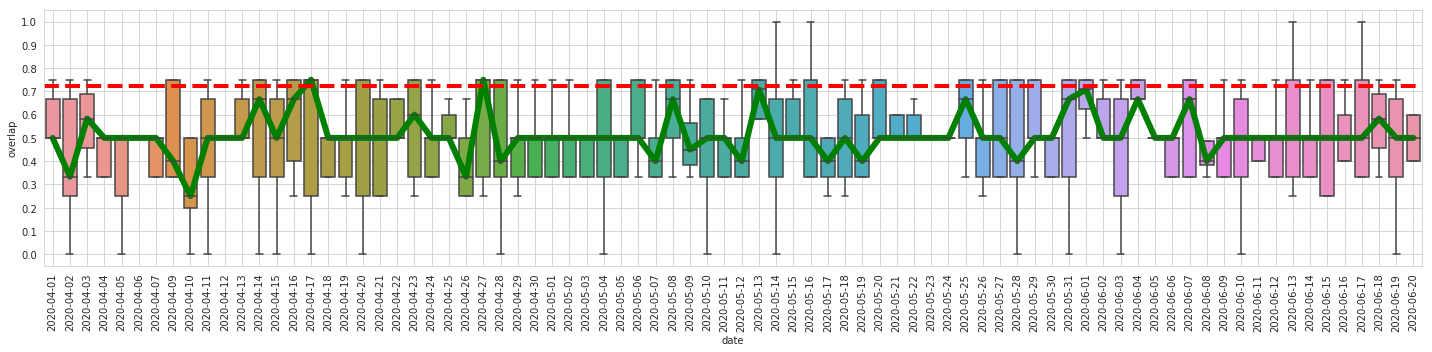

In [41]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='overlap',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='overlap',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,1.1,0.1))

ax.axhline(0.722, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("Destination overlap evolution");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'dest_overlap_prov_cluster.png'))

## Compare incoming flows

In [42]:
date_results_df=generate_comparive_fn(axis=1)

In [43]:
date_results_df.head()

,MA_id,corr,rmse,overlap,date
0,0,0.943836,0.004909,0.750000,2020-04-01
1,1,0.765824,0.023183,0.666667,2020-04-01
2,2,0.988384,0.066267,0.666667,2020-04-01
4,4,-0.866025,0.518519,0.000000,2020-04-01
5,total,0.835897,0.005106,1.000000,2020-04-01


In [44]:
date_results_df[date_results_df['MA_id']=='total']['rmse'].mean()

0.006812002160895447

In [45]:
date_results_df[date_results_df['MA_id']=='total']['overlap'].mean()

0.9529166666666666

In [46]:
date_results_df = date_results_df[date_results_df['MA_id']!= 'total']

### RMSE evol

In [47]:
median_date_results_df= date_results_df.groupby('date')['rmse'].median().to_frame()

In [48]:
median_date_results_df['rmse'].mean()

0.05284538480062506

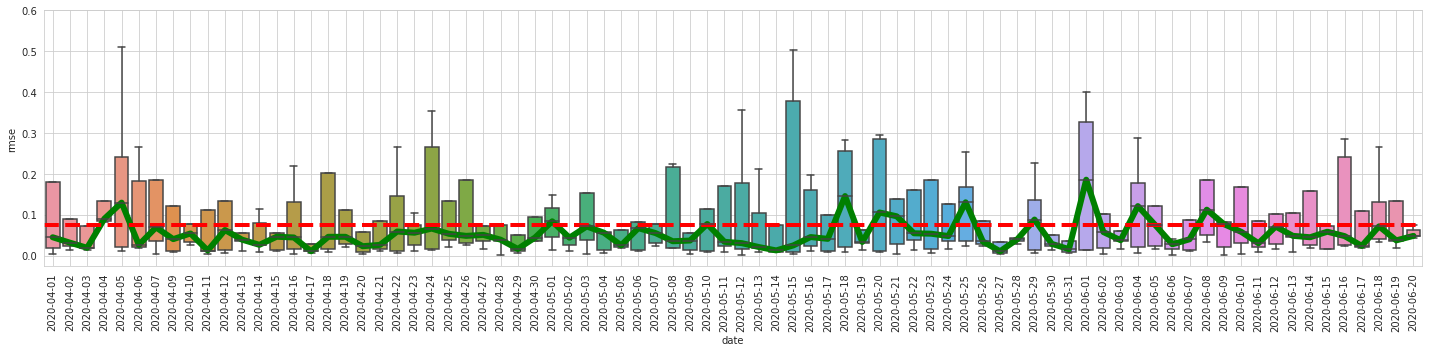

In [49]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='rmse',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='rmse',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,0.7,0.1))

ax.axhline(0.074, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("RMSE evolution (incoming flow)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'rmse_incoming_prov_cluster.png'))

### Origin overlap

In [50]:
median_date_results_df= date_results_df.groupby('date')['overlap'].median().to_frame()

In [51]:
median_date_results_df['overlap'].mean()

0.5110416666666666

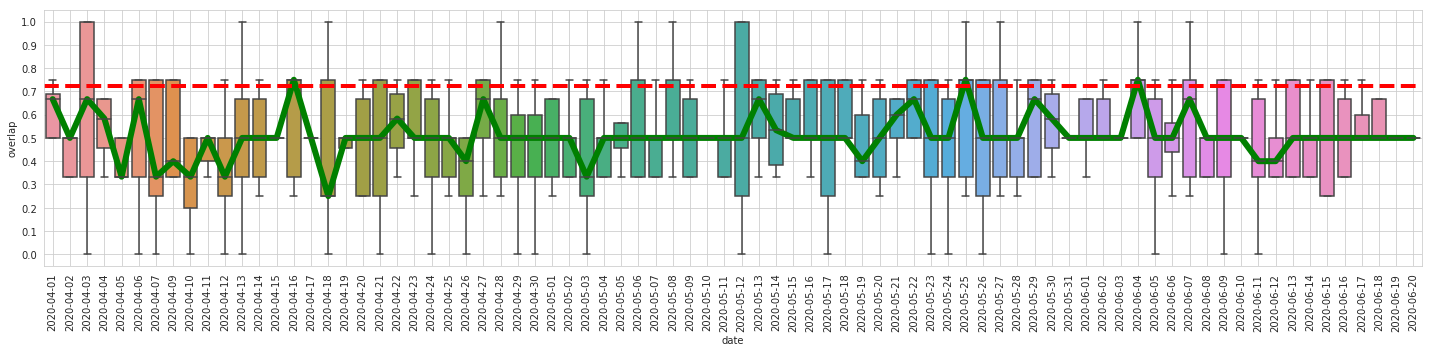

In [52]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='overlap',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='overlap',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,1.1,0.1))

ax.axhline(0.722, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("Origin overlap evolution");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'origin_overlap_prov_cluster.png'))

## Compare number of active MAs

In [53]:
def calculate_num_orig_dest_fn():
    results = []
    for d in tqdm_notebook(target_days):
        twt_n_origins = twt_ods[d][twt_ods[d]['total']>0].shape[0]-1
        twt_n_destinations = twt_ods[d].loc['total'][twt_ods[d].loc['total']>0].shape[0]-1
        
        results.append((twt_n_origins, 'origin', 'TWT',d))
        results.append((twt_n_destinations, 'destination', 'TWT',d))

        
        ine_n_origins = ine_ods[d][ine_ods[d]['total']>0].shape[0]-1
        ine_n_destinations =ine_ods[d].loc['total'][ine_ods[d].loc['total']>0].shape[0]-1
        
        results.append((ine_n_origins, 'origin', 'INE',d))
        results.append((ine_n_destinations, 'destination', 'INE',d))
        
    result_df= pd.DataFrame(results, columns='number type source date'.split())
    result_df['date'] = result_df['date'].astype(str)

    return result_df

In [54]:
n_origin_dest_df = calculate_num_orig_dest_fn()

In [55]:
n_origin_dest_df.head()

,number,type,source,date
0,5,origin,TWT,2020-04-01
1,5,destination,TWT,2020-04-01
2,5,origin,INE,2020-04-01
3,5,destination,INE,2020-04-01
4,5,origin,TWT,2020-04-02


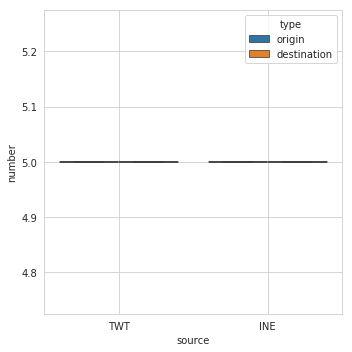

In [56]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_df, x='source', y='number',hue='type', showfliers = False);
ax.grid(True)
#plt.title("Number of origin-destinations (no threshold)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'num_origin_dest_prov_cluster.png'))

In [57]:
n_origin_df = n_origin_dest_df[n_origin_dest_df['type']=='origin']
n_dest_df = n_origin_dest_df[n_origin_dest_df['type']=='destination']

In [58]:
n_origin_df.head()

,number,type,source,date
0,5,origin,TWT,2020-04-01
2,5,origin,INE,2020-04-01
4,5,origin,TWT,2020-04-02
6,5,origin,INE,2020-04-02
8,5,origin,TWT,2020-04-03


### Number of MAs acting as trip origin

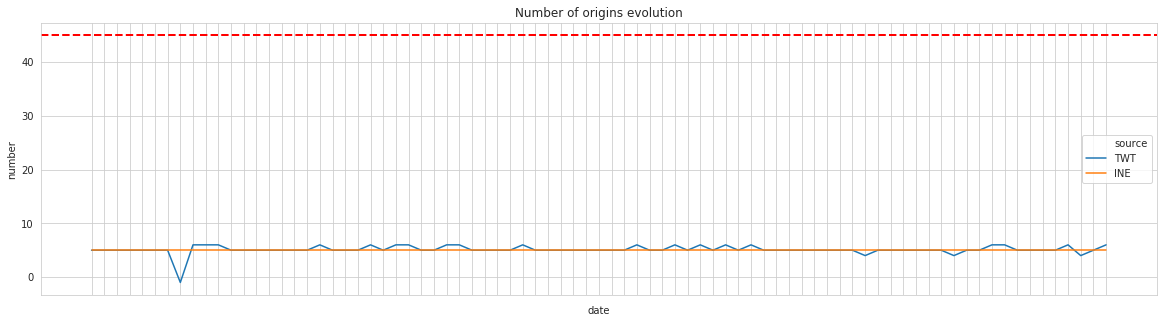

In [59]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")

ax = sns.lineplot(data=n_origin_df, x='date', y='number',hue='source')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.axhline(45, linewidth=2, color='red', linestyle='--')
#ax.axhline(2900, linewidth=2, color='red', linestyle='--')


ax.grid(True)
plt.title("Number of origins evolution");

#### Correlation

In [60]:
import scipy.stats as stats

In [61]:
r, p = stats.pearsonr(n_origin_df[n_origin_df['source']=='TWT']['number'], 
                      n_origin_df[n_origin_df['source']=='INE']['number'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: nan and p-value: 1.0


## Number of MAs acting as trip destinations

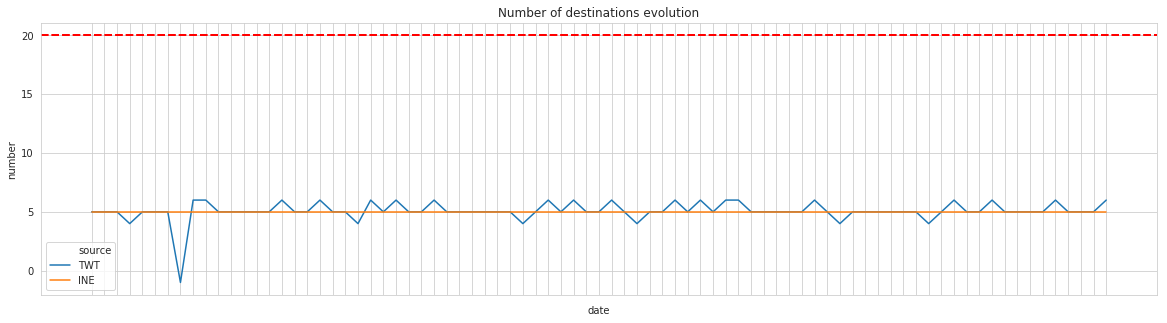

In [62]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")

ax = sns.lineplot(data=n_dest_df, x='date', y='number',hue='source')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.axhline(20, linewidth=2, color='red', linestyle='--')
ax.axhline(20, linewidth=2, color='red', linestyle='--')


ax.grid(True)
plt.title("Number of destinations evolution");

In [63]:
import scipy.stats as stats

#### Correlation

In [64]:
r, p = stats.pearsonr(n_dest_df[n_dest_df['source']=='TWT']['number'], 
                      n_dest_df[n_dest_df['source']=='INE']['number'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: nan and p-value: 1.0


## Evolution of the trips distances

In [65]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), encoding='utf-8').to_crs({'init': 'epsg:25830'})
province_gdf['CODEUNIT'] = province_gdf['CODEUNIT'].astype(int)
province_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,geometry
0,34104600000,València/Valencia,46,"MULTIPOLYGON (((653037.661 4429500.236, 652229..."
1,34084500000,Toledo,45,"POLYGON ((294238.465 4416957.428, 294235.467 4..."
2,34024400000,Teruel,44,"POLYGON ((765333.011 4512252.351, 764732.031 4..."
3,34094300000,Tarragona,43,"MULTIPOLYGON (((813560.435 4504876.753, 813537..."
4,34074200000,Soria,42,"POLYGON ((583890.589 4603311.305, 583939.589 4..."


In [66]:
prov_codes= province_gdf['CODEUNIT'].unique().tolist()

In [67]:
prov_distances_df = pd.DataFrame(0,columns=prov_codes, index=prov_codes)

In [68]:
from itertools import combinations

In [69]:
for o_prov, d_prov in combinations(prov_codes, r=2):
    po_centroid = province_gdf[province_gdf['CODEUNIT']==o_prov]['geometry'].iloc[0].centroid
    pd_centroid = province_gdf[province_gdf['CODEUNIT']==d_prov]['geometry'].iloc[0].centroid
    prov_distances_df.loc[o_prov,d_prov]= po_centroid.distance(pd_centroid)/1000
    prov_distances_df.loc[d_prov,o_prov]= po_centroid.distance(pd_centroid)/1000

In [70]:
prov_distances_df.head()

,46,45,44,43,42,41,40,39,37,36,...,3,2,1,-1,52,51,50,49,48,47
46,0.000000,291.368806,143.424029,235.275035,292.355203,477.344432,341.488288,503.798380,476.454614,729.672545,...,100.898049,118.694836,417.207349,559.437942,490.950246,556.180286,250.871945,510.686225,462.636302,425.150144
45,291.368806,0.000000,299.192009,444.805678,241.670532,294.067345,152.964485,377.991586,197.996684,466.343327,...,341.962578,215.553252,358.029028,445.000676,510.714048,445.545774,329.931798,264.480838,397.275429,212.540100
44,143.424029,299.192009,0.000000,145.666167,182.967735,552.581190,278.513249,387.685046,443.567313,667.479778,...,243.265583,226.876222,288.641268,662.740829,624.580339,660.566806,108.457713,448.759121,332.185007,354.972638
43,235.275035,444.805678,145.666167,0.000000,291.060130,691.757004,409.098550,464.036671,580.213566,785.759535,...,313.230066,346.757615,351.564891,790.480488,722.918368,787.647869,168.130881,572.439384,385.906541,477.592194
42,292.355203,241.670532,182.967735,291.060130,0.000000,535.233240,132.354162,211.503362,305.287156,494.798350,...,389.033447,314.588278,135.264216,679.308956,703.042258,679.060145,127.066348,282.478331,180.904116,188.077306


In [71]:
prov_distances_df.columns= prov_distances_df.columns.astype(str)
prov_distances_df.index= prov_distances_df.index.astype(str)

In [72]:
from statistics import median

def calculate_avg_distance_trips_fn(od):
    od_no_total =od.drop('total',axis=0)
    od_no_totals = od_no_total.drop('total', axis=1)
    results_df = od_no_totals.mul(prov_distances_df)
    total_sum_by_ma = results_df.sum(axis=1)
    avg_by_ma= (total_sum_by_ma /od['total']).fillna(0)
    nozero_avg= avg_by_ma[avg_by_ma>0]
    if len(nozero_avg)>0:
        #avg_dist = median(nozero_avg)#
        avg_dist = sum(nozero_avg)/len(nozero_avg)
        return avg_dist
    else:
        return 0

In [73]:
twt_avg_dist= []
for date, od in tqdm_notebook(twt_ods.items()): 
    dist_= calculate_avg_distance_trips_fn(od)
    twt_avg_dist.append((date, dist_))

In [74]:
twt_avg_dist_df = pd.DataFrame.from_records(twt_avg_dist,columns='date avg_dist'.split())
twt_avg_dist_df = twt_avg_dist_df.set_index('date')

In [75]:
ine_avg_dist= []
for date, od in tqdm_notebook(ine_ods.items()): 
    dist_= calculate_avg_distance_trips_fn(od)
    ine_avg_dist.append((date, dist_))

In [76]:
ine_avg_dist_df = pd.DataFrame.from_records(ine_avg_dist,columns='date avg_dist'.split())
ine_avg_dist_df = ine_avg_dist_df.set_index('date')

In [77]:
twt_avg_dist_df['ine_avg_dist']= ine_avg_dist_df['avg_dist']

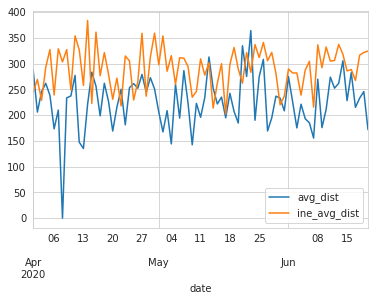

In [78]:
twt_avg_dist_df.plot(grid=True);

In [79]:
import scipy.stats as stats

In [80]:
r, p = stats.pearsonr(twt_avg_dist_df['avg_dist'], 
                      twt_avg_dist_df['ine_avg_dist'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.06926478966378263 and p-value: 0.5389295036170241


In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

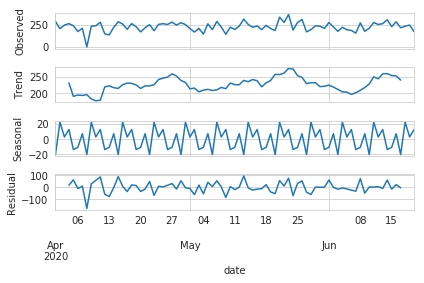

In [82]:
result = seasonal_decompose(twt_avg_dist_df['avg_dist'], model='additive', freq=7);
result.plot();

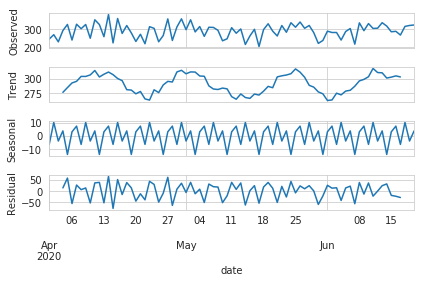

In [83]:
result = seasonal_decompose(twt_avg_dist_df['ine_avg_dist'], model='additive', freq=7);
result.plot();

# Evolution total num trips vs COVID cases

In [84]:
ine_covid_cases_df = pd.read_csv(os.path.join('data', 'COVID-19_cases_per_ine_cprov.csv'), index_col=0)
twt_covid_cases_df = pd.read_csv(os.path.join('data', 'COVID-19_cases_per_twt_cprov.csv'), index_col=0)

In [85]:
target_ine_covid_cases_df = ine_covid_cases_df[ine_covid_cases_df['mes'].isin([4, 5, 6])]
target_twt_covid_cases_df = twt_covid_cases_df[twt_covid_cases_df['mes'].isin([4, 5, 6])]

In [86]:
target_ine_covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
0,0,1,4,2930
1,0,2,4,2366
2,0,3,4,2341
3,0,4,4,1941
4,0,5,4,1643


In [87]:
target_twt_covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
0,0,1,4,2930
1,0,2,4,2366
2,0,3,4,2341
3,0,4,4,1941
4,0,5,4,1643


In [88]:
def calculate_accumulative_cases_fn(covid_df):
    result_covid_df = covid_df.copy()
    result_covid_df['cumulative_cases']=0
    for prov in tqdm_notebook(covid_df['Provincia_cod'].unique()):
        total_cases =0
        prov_covid_df = covid_df[covid_df['Provincia_cod']==prov]
        for month in [4, 5, 6]:
            #print('mes', month)
            days_list = prov_covid_df[prov_covid_df['mes']==month]['dia'].unique().tolist()
            days_list.sort()
            for day in days_list:
                #print(day)
                day_row = prov_covid_df[(prov_covid_df['mes']==month)& (prov_covid_df['dia']==day)]
                total_cases += day_row['num_casos'].values[0]
                #day_row['cumulative_cases'] = total_cases 
                #print(day_row.index[0], total_cases)
                result_covid_df.loc[day_row.index[0],'cumulative_cases']= total_cases
                #print(month, day, day_row,)
                
    return result_covid_df

In [89]:
ine_accumulative_covid_df = calculate_accumulative_cases_fn(target_ine_covid_cases_df)
twt_accumulative_covid_df = calculate_accumulative_cases_fn(target_twt_covid_cases_df)

In [90]:
ine_accumulative_covid_df.head()

,Provincia_cod,dia,mes,num_casos,cumulative_cases
0,0,1,4,2930,2930
1,0,2,4,2366,5296
2,0,3,4,2341,7637
3,0,4,4,1941,9578
4,0,5,4,1643,11221


In [91]:
twt_accumulative_covid_df.head()

,Provincia_cod,dia,mes,num_casos,cumulative_cases
0,0,1,4,2930,2930
1,0,2,4,2366,5296
2,0,3,4,2341,7637
3,0,4,4,1941,9578
4,0,5,4,1643,11221


In [92]:
import datetime

In [93]:
def generate_num_cases_trips_fn():
    num_cases_trips = []
    for date_ in twt_ods:
        twt_od = twt_ods[date_]
        n_twt_trips = twt_od.loc['total','total']
        ine_od = ine_ods[date_]
        n_ine_trips = ine_ods[date_].loc['total','total']
        month = date_.month
        day = date_.day
        n_covid_cases = ine_covid_cases_df[(ine_covid_cases_df['dia']==day) & (ine_covid_cases_df['mes']==month)]['num_casos'].sum()
        num_cases_trips.append((date_,n_twt_trips, n_ine_trips, n_covid_cases))
    
    df=  pd.DataFrame.from_records(num_cases_trips,columns='date n_twt_trips n_ine_trips COVID_cases'.split())
    return df.set_index('date')

In [94]:
trips_cases_df = generate_num_cases_trips_fn()

In [95]:
trips_cases_df.head()

,n_twt_trips,n_ine_trips,COVID_cases
date,,,
2020-04-01,166,2060,5687
2020-04-02,133,2146,4608
2020-04-03,145,2470,4605
2020-04-04,28,1904,3943
2020-04-05,106,2127,3501


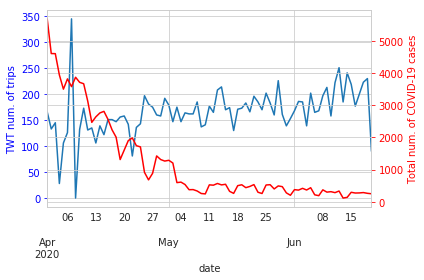

In [96]:
ax= trips_cases_df['n_twt_trips'].plot();
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
trips_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('TWT num. of trips')
ax2.set_ylabel('Total num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_n_trips_vs_covid_prov_cluster.png'))

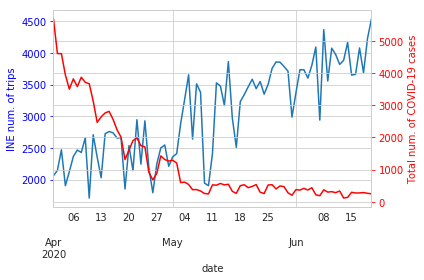

In [97]:
ax= trips_cases_df['n_ine_trips'].plot();
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
trips_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('INE num. of trips')
ax2.set_ylabel('Total num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_n_trips_vs_covid_prov_cluster.png'))

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

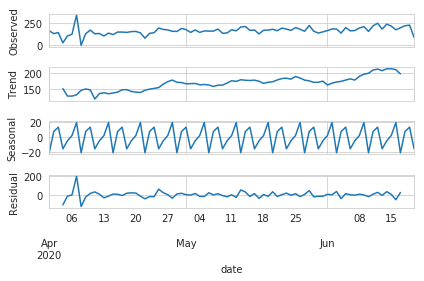

In [99]:
result = seasonal_decompose(trips_cases_df['n_twt_trips'], model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_n_trips_evol_prov_cluster.png'))

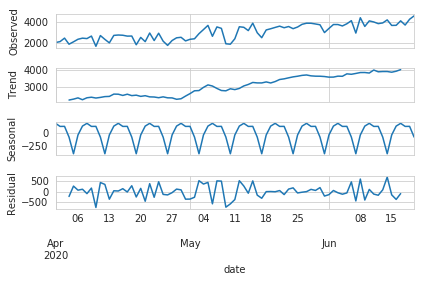

In [100]:
result = seasonal_decompose(trips_cases_df['n_ine_trips'], model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_n_trips_evol_prov_cluster.png'))

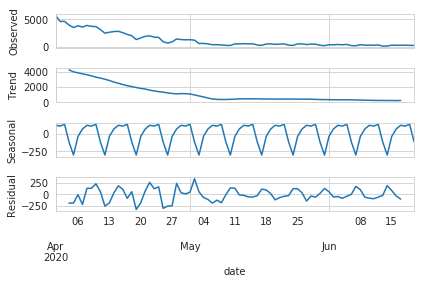

In [101]:
result = seasonal_decompose(trips_cases_df['COVID_cases'], model='additive', freq=7);
result.plot();

Correlation ine and twt trips

In [102]:
r, p = stats.pearsonr(trips_cases_df['n_twt_trips'], 
                      trips_cases_df['n_ine_trips'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.3775930909285697 and p-value: 0.0005106507110625488


In [103]:
r, p = stats.pearsonr(trips_cases_df['n_twt_trips'], 
                      trips_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.4018970996062198 and p-value: 0.00020005042871448217


In [104]:
r, p = stats.pearsonr(trips_cases_df['n_ine_trips'], 
                      trips_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.6230893490088986 and p-value: 5.236766601486908e-10


## Time Lagged Cross Correlation

In [105]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

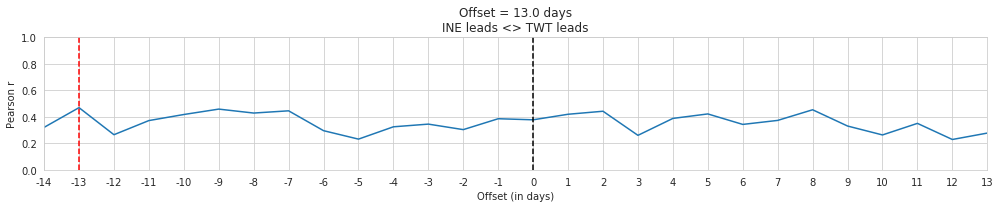

In [106]:
d1 = trips_cases_df['n_ine_trips']
d2 = trips_cases_df['n_twt_trips']
rs = [crosscorr(d1,d2, lag) for lag in range(-14,14)]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days\nINE leads <> TWT leads',ylim=[0.0,1],xlim=[0,24], xlabel='Offset (in days)',ylabel='Pearson r')
ax.set_xticks(np.arange(0,28))
ax.set_xticklabels(np.arange(-14,14));
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'time_lagged_correlation_prov_cluster.png'))

# Variation of mobility vs COVID

In [107]:
from datetime import date, timedelta

def generate_week_days_fn(init_date):

    target_days = []
    for i in range(7):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [108]:
weeks= []

#first week
e_date = datetime.datetime.strptime('2020-04-05', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
target_days_w1 = generate_target_days_fn(i_date, e_date)
weeks.append(target_days_w1)

for w in range(0,10):
    week_days = generate_week_days_fn(e_date + timedelta(days=1))
    weeks.append(week_days)
    e_date = week_days[-1]

#last week    
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-15', '%Y-%m-%d')
target_days_wf = generate_target_days_fn(i_date, e_date)
weeks.append(target_days_wf)

In [109]:
date_ = datetime.datetime.strptime('2020-04-12', '%Y-%m-%d')

twt_od = twt_ods[date_]

In [110]:
date_ = datetime.datetime.strptime('2020-04-12', '%Y-%m-%d')

twt_od = twt_ods[date_]

In [111]:
def get_trips_variation_fn(ods):
    previous_ntrips = []
    previous_ntrips_input= []
    i=1
    for w in weeks:
        prev_od = None
        for day in w:
            twt_od= ods[day]
            if prev_od is not None:
                prev_od = prev_od.add(twt_od, axis=1)
            else:
                prev_od = twt_od
        previous_ntrips.append(prev_od['total'])
        previous_ntrips_input.append(prev_od.loc['total'].T)
        
        i += 1
    n_trips_diff = []
    for i in range(0,len(previous_ntrips)-1):
        
        #Difference in the number of outgoing trips
        trips_week_prev = previous_ntrips[i]
        trips_week_curr = previous_ntrips[i+1]
        diff = ((trips_week_curr-trips_week_prev)/(trips_week_curr+trips_week_prev))*100
        
        #Difference in the number of incoming trips
        trips_week_prev_input = previous_ntrips_input[i]
        trips_week_curr_input = previous_ntrips_input[i+1]
        diff_input = ((trips_week_curr_input-trips_week_prev_input)/(trips_week_curr_input+trips_week_prev_input))*100

        diff_df = diff.to_frame()
        diff_df['input_trips_diff']= diff_input
        
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={'index':'prov', 'total':'trips_diff'})
        diff_df['week']= i+1
        n_trips_diff.append(diff_df)
    
    df_ = pd.concat(n_trips_diff, axis=0)
    df=df_.dropna(axis=0)
    return df_.reset_index()

In [112]:
twt_ntrips_diff = get_trips_variation_fn(twt_ods)

In [113]:
twt_ntrips_diff.tail()

,index,prov,trips_diff,input_trips_diff,week
83,3,3,2.645503,-5.600000,11
84,4,4,-20.000000,0.000000,11
85,5,6,NaN,NaN,11
86,6,5,-14.285714,0.000000,11
87,7,total,-12.586339,-12.586339,11


In [114]:
ine_ntrips_diff = get_trips_variation_fn(ine_ods)

In [115]:
ine_ntrips_diff.head()

,index,prov,trips_diff,input_trips_diff,week
0,0,0,19.249442,20.751083,1
1,1,1,20.463768,18.882283,1
2,2,2,22.547694,15.619335,1
3,3,3,25.693731,19.388869,1
4,4,4,29.407146,45.304194,1


In [116]:
twt_covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
0,0,1,4,2930
1,0,2,4,2366
2,0,3,4,2341
3,0,4,4,1941
4,0,5,4,1643


In [117]:
def calculate_covid_cases_diff_fn(covid_cases_df, accumulative_covid_df):
    prev_week_cases = None
    covid_cases_diff = []
    nweek=1
    for w in weeks:
        curr_week_cases = dict.fromkeys([prov for prov in covid_cases_df['Provincia_cod'].unique()],0)

        for date in w:
            day = date.day
            month = date.month
            date_covid = accumulative_covid_df[(covid_cases_df['dia']==day) & 
                                               (covid_cases_df['mes']==month)]

            for prov in date_covid['Provincia_cod'].unique():
                curr_week_cases[prov] += date_covid[date_covid['Provincia_cod']==prov]['num_casos'].values[0]

        if prev_week_cases is not None:
            diff_dict = {k: ((curr_week_cases.get(k, 0) - prev_week_cases.get(k, 0))/(curr_week_cases.get(k, 0) + prev_week_cases.get(k, 0)))*100 
                         for k in set(curr_week_cases)}
            covid_cases_diff.append(diff_dict)     
        prev_week_cases = curr_week_cases
        
    return covid_cases_diff

In [118]:
twt_covid_cases_diff = calculate_covid_cases_diff_fn(twt_covid_cases_df, twt_accumulative_covid_df)

In [119]:
ine_covid_cases_diff = calculate_covid_cases_diff_fn(ine_covid_cases_df, ine_accumulative_covid_df)

In [120]:
"""
prev_week_cases = None
covid_cases_diff = []
nweek=1
for w in weeks:
    curr_week_cases = dict.fromkeys([prov for prov in twt_covid_cases_df['Provincia_cod'].unique()],0)

    for date in w:
        day = date.day
        month = date.month
        date_covid = twt_accumulative_covid_df[(twt_covid_cases_df['dia']==day) & 
                                           (twt_covid_cases_df['mes']==month)]
        
        for prov in date_covid['Provincia_cod'].unique():
            curr_week_cases[prov] += date_covid[date_covid['Provincia_cod']==prov]['num_casos'].values[0]
    
    if prev_week_cases is not None:
        diff_dict = {k: ((curr_week_cases.get(k, 0) - prev_week_cases.get(k, 0))/(curr_week_cases.get(k, 0) + prev_week_cases.get(k, 0)))*100 
                     for k in set(curr_week_cases)}
        covid_cases_diff.append(diff_dict)     
    prev_week_cases = curr_week_cases

"""

"\nprev_week_cases = None\ncovid_cases_diff = []\nnweek=1\nfor w in weeks:\n    curr_week_cases = dict.fromkeys([prov for prov in twt_covid_cases_df['Provincia_cod'].unique()],0)\n\n    for date in w:\n        day = date.day\n        month = date.month\n        date_covid = twt_accumulative_covid_df[(twt_covid_cases_df['dia']==day) & \n                                           (twt_covid_cases_df['mes']==month)]\n        \n        for prov in date_covid['Provincia_cod'].unique():\n            curr_week_cases[prov] += date_covid[date_covid['Provincia_cod']==prov]['num_casos'].values[0]\n    \n    if prev_week_cases is not None:\n        diff_dict = {k: ((curr_week_cases.get(k, 0) - prev_week_cases.get(k, 0))/(curr_week_cases.get(k, 0) + prev_week_cases.get(k, 0)))*100 \n                     for k in set(curr_week_cases)}\n        covid_cases_diff.append(diff_dict)     \n    prev_week_cases = curr_week_cases\n\n"

In [121]:
twt_ntrips_diff.tail()

,index,prov,trips_diff,input_trips_diff,week
83,3,3,2.645503,-5.600000,11
84,4,4,-20.000000,0.000000,11
85,5,6,NaN,NaN,11
86,6,5,-14.285714,0.000000,11
87,7,total,-12.586339,-12.586339,11


In [122]:
def add_covid_diff_cases_fn(n_trips_diff_df, covid_cases_diff):
    n_trips_diff_df['covid_diff']=0
    week_num = 1
    for diff in covid_cases_diff:
        for prov, cases_var in diff.items():
            target_df = n_trips_diff_df[(n_trips_diff_df['prov']==str(prov)) & (n_trips_diff_df['week']==week_num)]
            index = target_df.index.tolist()[0]
            n_trips_diff_df.loc[index, 'covid_diff']= cases_var
            
        week_num += 1
    return n_trips_diff_df

In [123]:
twt_diff_df= add_covid_diff_cases_fn(twt_ntrips_diff, twt_covid_cases_diff)

In [124]:
twt_diff_df.head()

,index,prov,trips_diff,input_trips_diff,week,covid_diff
0,0,0,26.819923,35.593220,1,4.163642
1,1,1,26.693227,20.833333,1,2.702703
2,2,2,28.404669,27.196653,1,4.663774
3,3,3,32.862191,33.858268,1,6.916277
4,4,4,36.000000,15.625000,1,-5.914567


### TWT outgoing trips

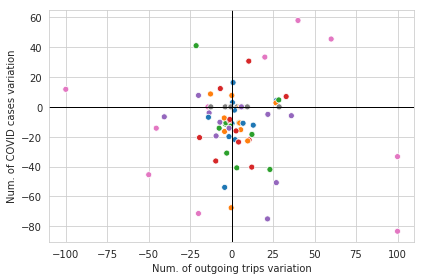

In [125]:
ax =sns.scatterplot(x="trips_diff", y="covid_diff", hue="prov", data=twt_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_covid_vs_outgoing_trips_prov_cluster.png'))

### TWT incoming trips

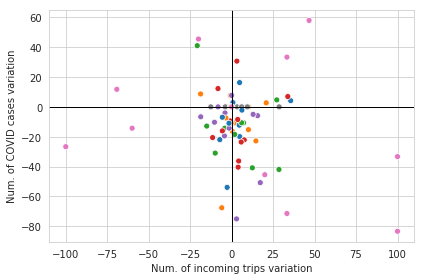

In [126]:
ax =sns.scatterplot(x="input_trips_diff", y="covid_diff", hue="prov", data=twt_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_covid_vs_incoming_trips_prov_cluster.png'))

### Correlation study

#### TWT

In [127]:
df_ = twt_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.08715743304994034 and p-value: 0.4540654569763425


In [128]:
df_ = twt_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['input_trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.25238192553987093 and p-value: 0.02784320219051847


#### INE

In [129]:
ine_diff_df= add_covid_diff_cases_fn(ine_ntrips_diff, ine_covid_cases_diff)

In [130]:
df_ = ine_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.1345635961286889 and p-value: 0.2813816034187802


In [131]:
df_ = ine_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['input_trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.06242835805199936 and p-value: 0.6185078421558817


### INE outgoing trips

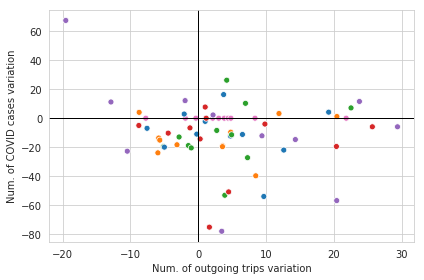

In [132]:
ax =sns.scatterplot(x="trips_diff", y="covid_diff", hue="prov", data=ine_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_covid_vs_outgoing_trips_prov_cluster.png'))

### INE incoming trips

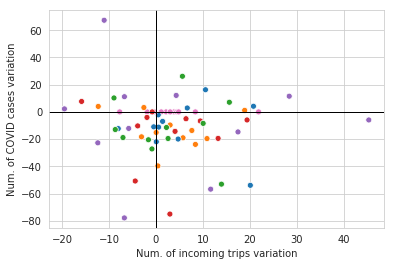

In [133]:
ax =sns.scatterplot(x="input_trips_diff", y="covid_diff", hue="prov", data=ine_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.savefig(os.path.join('figs', 'ine_covid_vs_incoming_trips_prov_cluster.png'))

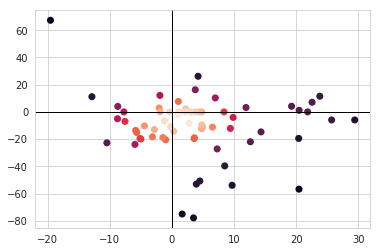

In [134]:
from scipy.stats import gaussian_kde

df_ = ine_diff_df.dropna(axis=0)
# Calculate the point density
x= df_['trips_diff'].values
y= df_['covid_diff'].values
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
plt.show()

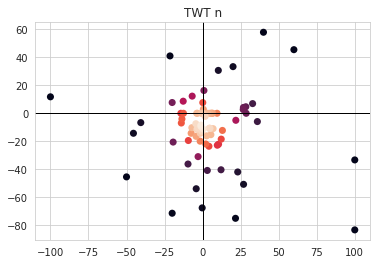

In [135]:
df_ = twt_diff_df.dropna(axis=0)
x= df_['trips_diff'].values
y= df_['covid_diff'].values
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_title("TWT n")
plt.show()

# Chord plot

In [136]:
from matplotlib_chord import chordDiagram, hex2rgb

def generate_chord_plot(df, df_type):
    X= df.to_numpy()
    
    ax = plt.axes([0,0,2,3])

    #nodePos = chordDiagram(X, ax, colors=[hex2rgb(x) for x in ['#1F77B4', '#50A02C', '#8C564B', '#7F7F7F', '#17BECF']])
    nodePos = chordDiagram(X, ax, colors=sns.color_palette("muted", df.shape[0]))
    ax.axis('off')
    prop = dict(fontsize=16*2, ha='center', va='center')
    nodes = df.index
    for i in range(len(nodes)):
        ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][2], **prop)
    
    ax.plot()
    plt.savefig(os.path.join('figs', 'chord_{}_prov_cluster.png'.format(df_type)), dpi=600,
            transparent=True,
            bbox_inches='tight', pad_inches=0.02)

## TWT

In [137]:
twt_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov_cluster.csv'), index_col=0)
twt_od_global = twt_od_global.drop(columns='total')
twt_od_global = twt_od_global.drop('total')

In [138]:
twt_od_global.head()

,0,1,2,3,4,6,5
0,0,10548,8914,62191,604,0,23
1,62280,0,15840,1288,2575,0,141
2,1914,2957,0,6252,16,0,0
3,732,1677,51,0,14,0,0
4,466,16503,1006,153,0,0,11


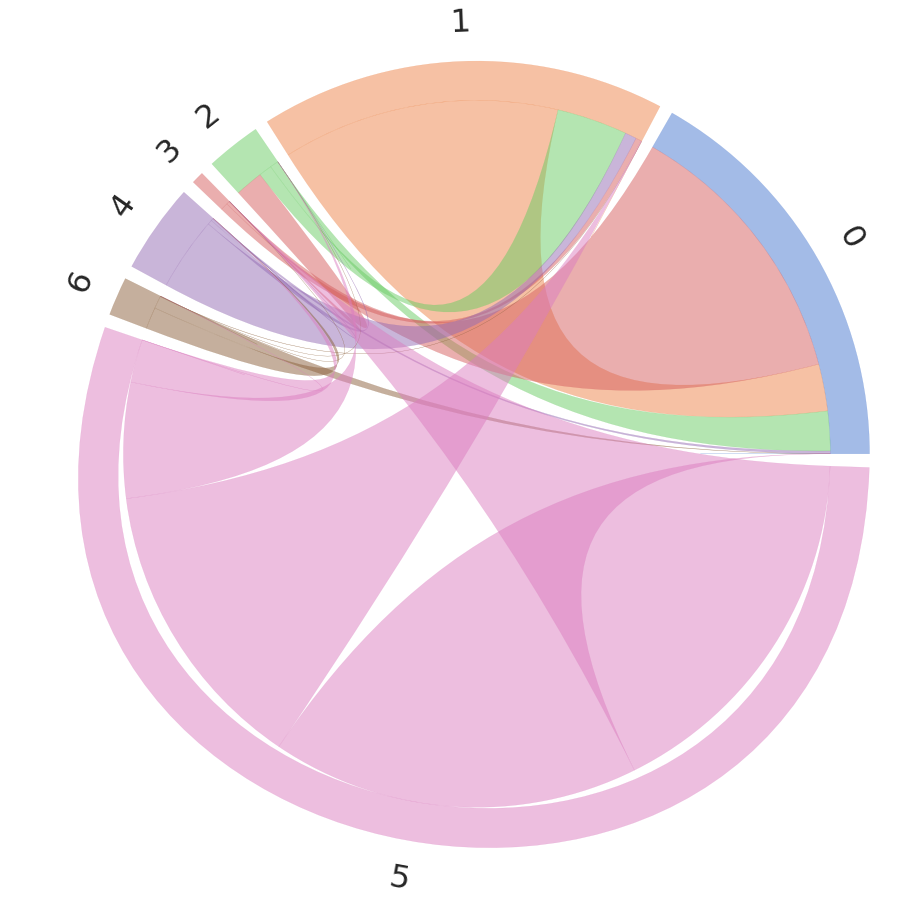

In [139]:
generate_chord_plot(twt_od_global, 'TWT')

## INE

In [140]:
ine_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD_prov_cluster.csv'), index_col=0)
ine_od_global = ine_od_global.drop(columns='total')
ine_od_global = ine_od_global.drop('total')

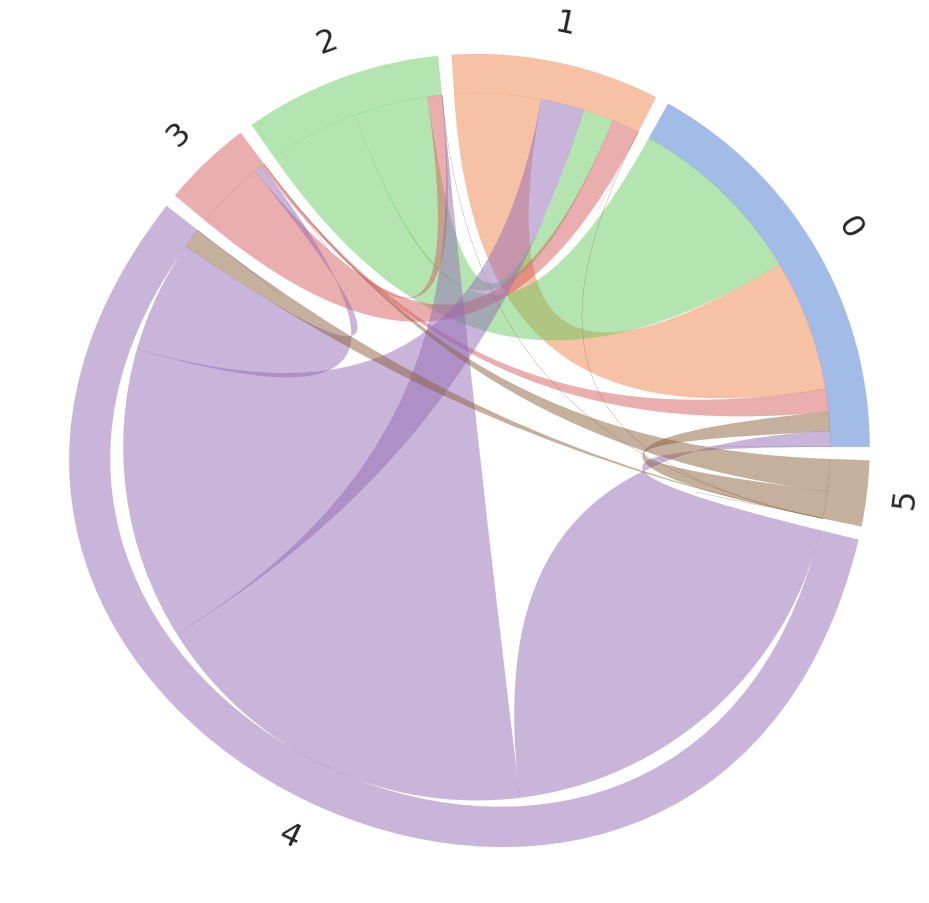

In [141]:
generate_chord_plot(ine_od_global, 'INE')

------------------------------

In [142]:
print("That's all folks")

That's all folks
